# <font color='#4C6FF3'>Twitter EDA</font>

In [1]:
# Suppress runtime warnings
import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy
from sqlalchemy import create_engine, MetaData, Table
from sqlalchemy.sql import select

In [3]:
db_uri = \
'mysql+pymysql://<user_and_password>@<EC2 DNS>'                                 

engine = create_engine(db_uri)                                                                                                                    
meta = MetaData()                                                           
meta.reflect(bind=engine)                                                   
conn = engine.connect()

In [4]:
twts = pd.read_sql('''SELECT * FROM tweets''', conn)

In [5]:
twts.head(2)

,uid,tweet,polarity,subjectivity,retweets,followers,neg,pos,neu,comp,created_at,timestp
0,003dee2a-1e70-11e7-aebd-02e3a62c6c04,Bitcoin-Core developer's mailing list calls fo...,0,0,0,13831,0,0,1,0,2017-04-11 04:33:24,2017-04-11 04:33:24
1,005cebb6-1e63-11e7-aebd-02e3a62c6c04,Check out our other BitCoin Investment Ideas\n...,-0.125,0.375,0,311602,0,0,1,0,2017-04-11 03:00:21,2017-04-11 03:00:21


#### Convert to proper dtypes

In [6]:
twts.polarity     = pd.to_numeric(twts.polarity)
twts.subjectivity = pd.to_numeric(twts.subjectivity)
twts.retweets     = pd.to_numeric(twts.retweets)
twts.followers    = pd.to_numeric(twts.followers)
twts.neg          = pd.to_numeric(twts.neg)
twts.pos          = pd.to_numeric(twts.pos)
twts.neu          = pd.to_numeric(twts.neu)
twts.comp         = pd.to_numeric(twts.comp)
twts.created_at   = pd.to_datetime(twts.created_at)

In [7]:
twts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 957378 entries, 0 to 957377
Data columns (total 12 columns):
uid             957378 non-null object
tweet           957378 non-null object
polarity        957378 non-null float64
subjectivity    957378 non-null float64
retweets        957378 non-null int64
followers       957378 non-null int64
neg             957378 non-null float64
pos             957378 non-null float64
neu             957378 non-null float64
comp            957378 non-null float64
created_at      957378 non-null datetime64[ns]
timestp         898507 non-null datetime64[ns]
dtypes: datetime64[ns](2), float64(6), int64(2), object(2)
memory usage: 87.7+ MB


In [8]:
# Change column name to allow merging with bpi DataFrame on column 'date'
twts.columns = ['uid', 'tweet', 'polarity', 'subjectivity', 'retweets', 'followers', 'neg', 'pos', 'neu', 'comp', 'date', 'timestp']
twts.columns

Index([u'uid', u'tweet', u'polarity', u'subjectivity', u'retweets',
       u'followers', u'neg', u'pos', u'neu', u'comp', u'date', u'timestp'],
      dtype='object')

In [9]:
bpi = pd.read_sql('''SELECT * FROM coindsk_bpi''', conn)

In [10]:
bpi.head(3)

,date,btc_usd_rate
0,2013-01-01,13.3041
1,2013-01-02,13.28
2,2013-01-03,13.3979


In [11]:
bpi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1578 entries, 0 to 1577
Data columns (total 2 columns):
date            1578 non-null object
btc_usd_rate    1578 non-null object
dtypes: object(2)
memory usage: 24.7+ KB


In [12]:
bpi.date         = pd.to_datetime(bpi.date)
bpi.btc_usd_rate = pd.to_numeric(bpi.btc_usd_rate)

#### Add Bitcoin Price Index to DataFrame containing tweets

In [13]:
twt_bpi = twts.merge(bpi, on='date').set_index('date', drop=False)
del twt_bpi.index.name
twt_bpi.head(3)

,uid,tweet,polarity,subjectivity,retweets,followers,neg,pos,neu,comp,date,timestp,btc_usd_rate
2013-01-02,60907f9a-1ecf-11e7-953e-0ad259645406,17kc7ncv just won 8.551 Bitcoins at http:// Sa...,0.5,0.75,0,0,0.0,0.266,0.734,0.6114,2013-01-02,NaT,13.28
2013-01-02,60908756-1ecf-11e7-953e-0ad259645406,17kc7ncv just won 8.551 Bitcoins at http:// Sa...,0.5,0.75,0,0,0.0,0.266,0.734,0.6114,2013-01-02,NaT,13.28
2013-01-02,60908d1e-1ecf-11e7-953e-0ad259645406,Is there any way to track the holder of a Bitc...,0.0,0.00,0,0,0.0,0.000,1.000,0.0000,2013-01-02,NaT,13.28


## <font color='#4C6FF3'>Daily Tweet Volume</font>

### <font color='#52B26C'>*Non-Unique Tweets (includes re-tweets)*</font>

#### <font color='#FF8253'>Conclusion: Insignificant positive correlation</font>

#### Add daily total of non-unique tweets (i.e., includes re-tweets) to `twt_bpi` DataFrame


In [14]:
twt_bpi['non_uniq_twts_per_day'] = twt_bpi.groupby(twt_bpi.index).tweet.count()

In [15]:
twt_bpi[['non_uniq_twts_per_day', 'btc_usd_rate']].corr()

,non_uniq_twts_per_day,btc_usd_rate
non_uniq_twts_per_day,1.000000,0.350978
btc_usd_rate,0.350978,1.000000


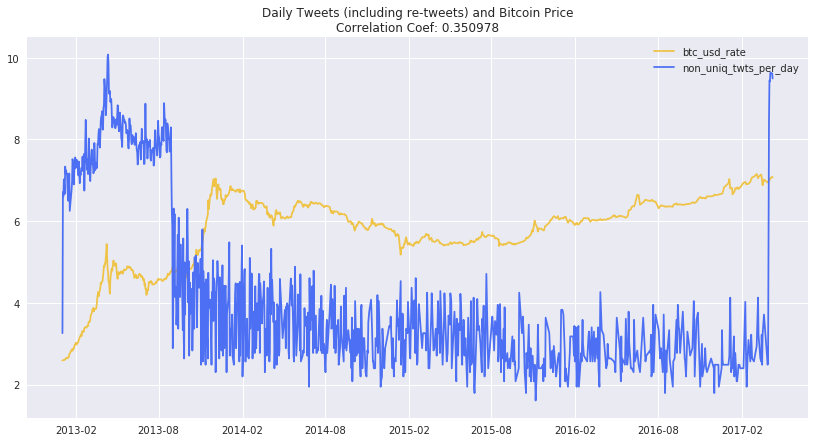

In [16]:
plt.figure(figsize=(14,7))
plt.plot(np.log(twt_bpi.btc_usd_rate), color='#EFC345')
plt.plot(np.log(twt_bpi.non_uniq_twts_per_day), color='#4C6FF3')
plt.legend(loc='upper right')
plt.title('Daily Tweets (including re-tweets) and Bitcoin Price\nCorrelation Coef: 0.350978')
plt.show();

### <font color='#52B26C'>*Unique Tweets (no re-tweets)*</font>

#### <font color='#FF8253'>Conclusion: Insignificant positive correlation</font>

In [17]:
uniq_twts_per_day = twt_bpi.join(twt_bpi.groupby(twt_bpi.index)['tweet'].apply(lambda x: len(x.unique())), on='date', rsuffix='_r')

In [29]:
uniq_twts_per_day[['tweet_r', 'btc_usd_rate']].corr()

,tweet_r,btc_usd_rate
tweet_r,1.000000,0.376607
btc_usd_rate,0.376607,1.000000


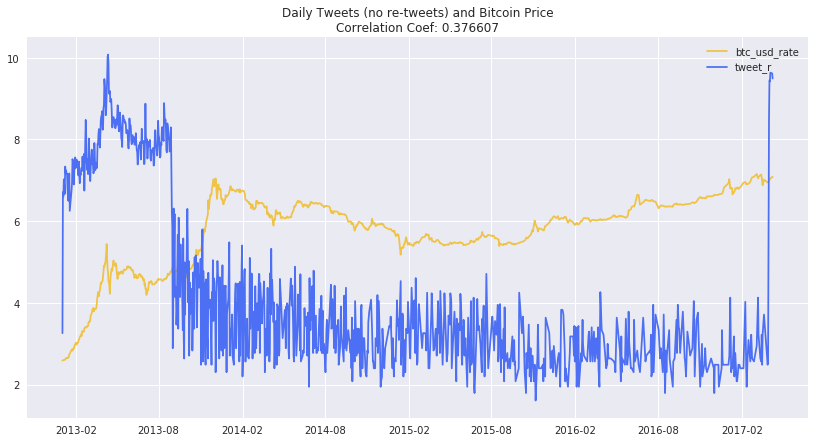

In [31]:
plt.figure(figsize=(14,7))
plt.plot(np.log(twt_bpi.btc_usd_rate), color='#EFC345')
plt.plot(np.log(uniq_twts_per_day.groupby('date').tweet_r.count()), color='#4C6FF3')
plt.legend(loc='upper right')
plt.title('Daily Tweets (no re-tweets) and Bitcoin Price\nCorrelation Coef: 0.376607')
plt.show();

## <font color='#4C6FF3'>Tweet Sentiment</font>

#### VADER for Sentiment Analysis
VADER: <font color='#4C6FF3'>
**V**alence **A**ware **D**ictionary s**E**ntiment **R**easoner</font>

See [here](https://github.com/cjhutto/vaderSentiment) for more details
 - <font color='#4C6FF3'>***Especially designed for Twitter***</font> (dictionary contains emoticons and slang)
 - Created using human ratings

<font color='green'>**(normalized, weighted) `compound`**</font> score: sum of valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between 
 - **-1** (most extreme negative) and 
 - **+1** (most extreme positive). 

This is <font color='green'>** the most useful metric if you want a single unidimensional measure of sentiment for a given sentence **</font>. 

**`pos`**, **`neu`**, and **`neg`**: ratios for proportions of text that fall in each category

In [69]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentences = list(twts.tweet[:20])
analyzer = SentimentIntensityAnalyzer()

### <font color='#52B26C'>*Overall Sentiment*</font>
#### <font color='#FF8253'>Conclusion: Insignificant positive correlation</font>

In [43]:
twt_bpi_corr = twt_bpi[['polarity', 'subjectivity', 'neg', 'pos', 'neu', 'comp', 'btc_usd_rate']].corr()
twt_bpi_corr

,polarity,subjectivity,neg,pos,neu,comp,btc_usd_rate
polarity,1.000000,0.349411,-0.200054,0.440903,-0.228149,0.486800,0.005685
subjectivity,0.349411,1.000000,0.236102,0.409093,-0.468852,0.209282,-0.011898
neg,-0.200054,0.236102,1.000000,-0.006351,-0.605001,-0.570556,-0.020450
pos,0.440903,0.409093,-0.006351,1.000000,-0.790528,0.752939,0.002604
neu,-0.228149,-0.468852,-0.605001,-0.790528,1.000000,-0.250064,0.009225
comp,0.486800,0.209282,-0.570556,0.752939,-0.250064,1.000000,0.006811
btc_usd_rate,0.005685,-0.011898,-0.020450,0.002604,0.009225,0.006811,1.000000


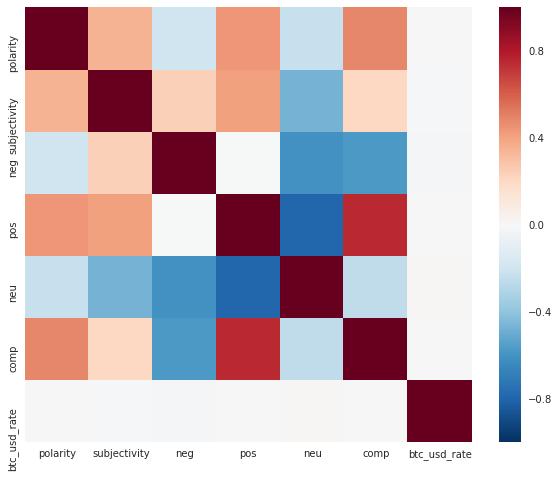

In [44]:
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(twt_bpi_corr);

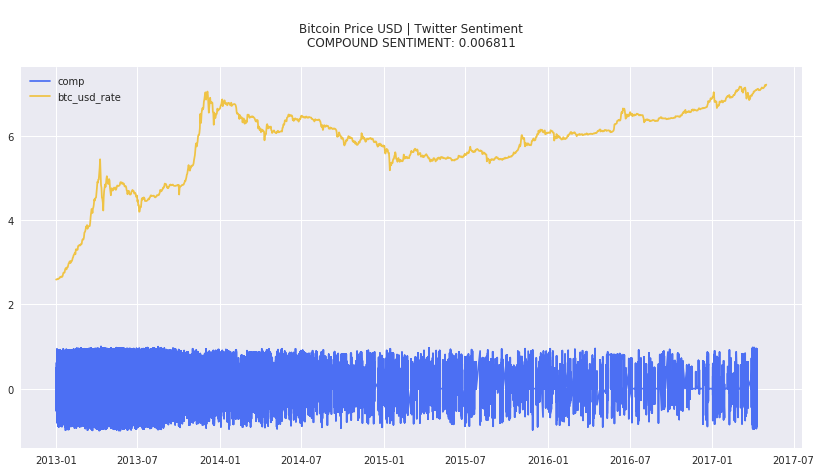

In [63]:
plt.figure(figsize=(14,7))
plt.plot(twt_bpi.date, twt_bpi.comp, color='#4C6FF3')
plt.plot(bpi.date, np.log(bpi.btc_usd_rate), color='#EFC345')
plt.legend(loc='upper left')
plt.title('''
Bitcoin Price USD | Twitter Sentiment
COMPOUND SENTIMENT: 0.006811
''')
plt.show();

### <font color='#52B26C'>*Positive Sentiment*</font>
#### <font color='#FF8253'>Conclusion: Insignificant positive correlation</font>

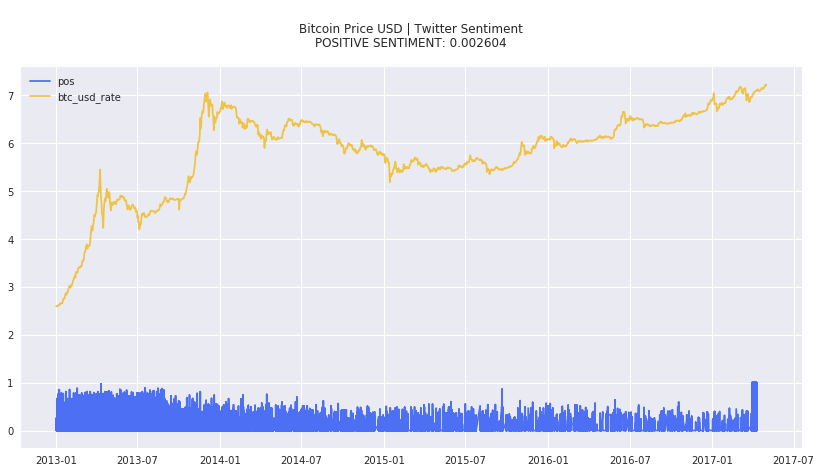

In [65]:
plt.figure(figsize=(14,7))
plt.plot(twt_bpi.date, twt_bpi.pos, color='#4C6FF3')
plt.plot(bpi.date, np.log(bpi.btc_usd_rate), color='#EFC345')
plt.legend(loc='upper left')
plt.title('''
Bitcoin Price USD | Twitter Sentiment
POSITIVE SENTIMENT: 0.002604
''')
plt.show();

### <font color='#52B26C'>*Negative Sentiment*</font>
#### <font color='#FF8253'>Conclusion: Insignificant negative correlation</font>

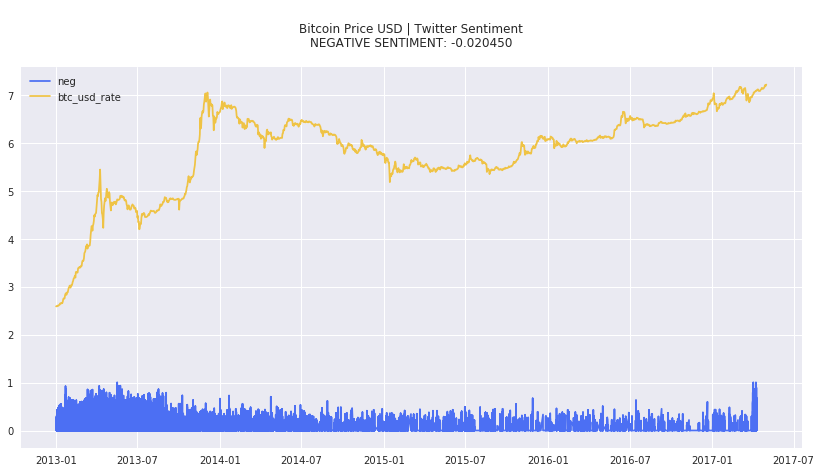

In [66]:
plt.figure(figsize=(14,7))
plt.plot(twt_bpi.date, twt_bpi.neg, color='#4C6FF3')
plt.plot(bpi.date, np.log(bpi.btc_usd_rate), color='#EFC345')
plt.legend(loc='upper left')
plt.title('''
Bitcoin Price USD | Twitter Sentiment
NEGATIVE SENTIMENT: -0.020450
''')
plt.show();